# Weather Forecasting with LSTM for the next 2 days



In [1]:
!python --version

Python 3.9.18


# Prepare the data

In [2]:
import pandas as pd
# Have a look at the data
df = pd.read_csv('data\Environment variables-data-as-seriestocolumns-2022-03-01 16_36_12.csv')
df.shape


(62724, 4)

In [3]:
df.head()

,Time,TF.insideEnvironment.insideHumidity,TF.insideEnvironment.insideLight,TF.insideEnvironment.insideTemperature
0,2022-02-28 06:00:01,29.0,0.14,25.0
1,2022-02-28 06:00:01,29.0,NaN,NaN
2,2022-02-28 06:00:05,29.0,NaN,NaN
3,2022-02-28 06:00:06,29.0,NaN,NaN
4,2022-02-28 06:00:11,29.0,NaN,NaN


In Excel I had a look over the data and saw lots of duplicates and missing values. I will have to clean the data before I can work with it.

In [4]:
df.drop_duplicates(inplace=True)
df.shape

(43471, 4)

In [5]:
# count the duplicates that are left
df.duplicated().sum()

0

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43471 entries, 0 to 62722
Data columns (total 4 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Time                                    43471 non-null  object 
 1   TF.insideEnvironment.insideHumidity     23816 non-null  float64
 2   TF.insideEnvironment.insideLight        10153 non-null  float64
 3   TF.insideEnvironment.insideTemperature  9508 non-null   float64
dtypes: float64(3), object(1)
memory usage: 1.7+ MB


So we have a different amount of data points for each column. We will have to interpolate the data to get a consistent dataset.
But first lets rename the columns to make them more readable.

In [7]:
#rename the columns
df.columns = ['Time', 'Humidity', 'Light', 'Temperature']
df.head()

,Time,Humidity,Light,Temperature
0,2022-02-28 06:00:01,29.0,0.14,25.0
1,2022-02-28 06:00:01,29.0,NaN,NaN
2,2022-02-28 06:00:05,29.0,NaN,NaN
3,2022-02-28 06:00:06,29.0,NaN,NaN
4,2022-02-28 06:00:11,29.0,NaN,NaN


# Visualize the data, Interpolating

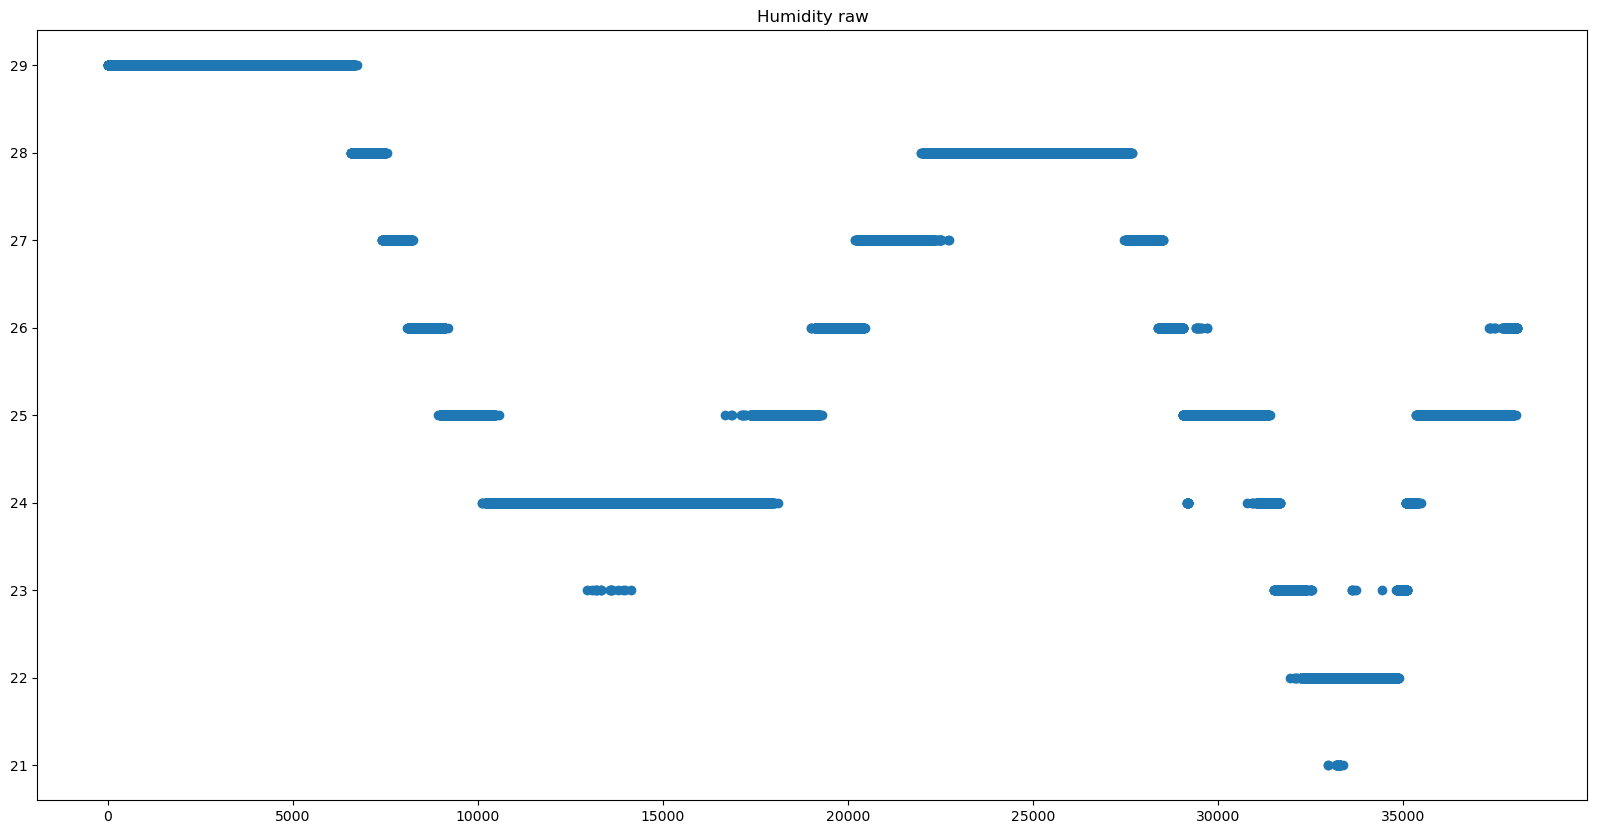

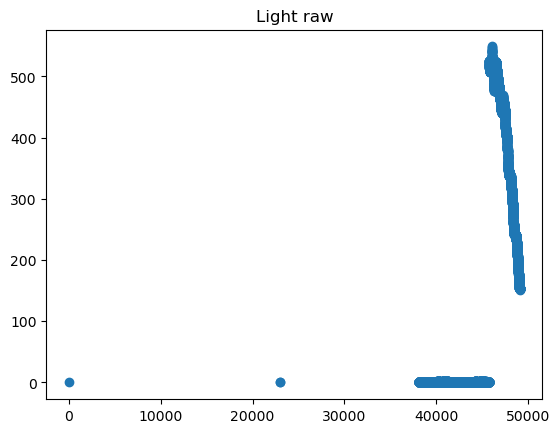

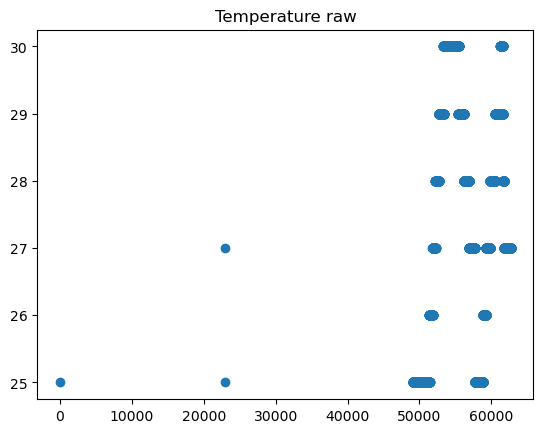

In [8]:
# import matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.plot(df['Humidity'], marker='o', linestyle='', label='Humidity')
plt.title('Humidity raw')
plt.show()
plt.plot(df['Light'], marker='o', linestyle='', label='Light')
plt.title('Light raw')
plt.show()
plt.plot(df['Temperature'], marker='o', linestyle='', label='Temperature')
plt.title('Temperature raw')
plt.show()

In [9]:
# to be able to use method 'time' we need to convert the Time column to datetime
df['Time'] = pd.to_datetime(df['Time'])
# set the Time column as index
df.set_index('Time', inplace=True)

# interpolate the data
df_ip = df.copy()
df_ip.interpolate(method='time', inplace=True)
df_ip.head()


,Humidity,Light,Temperature
Time,,,
2022-02-28 06:00:01,29.0,0.140000,25.0
2022-02-28 06:00:01,29.0,0.140000,25.0
2022-02-28 06:00:05,29.0,0.140149,25.0
2022-02-28 06:00:06,29.0,0.140186,25.0
2022-02-28 06:00:11,29.0,0.140372,25.0


In [10]:
# resample the data to have a consistent time interval
df_ip = df_ip.resample('5min').mean()
df_ip.loc['2022-02-28']

,Humidity,Light,Temperature
Time,,,
2022-02-28 06:00:00,29.0,0.145460,25.0
2022-02-28 06:05:00,29.0,0.156587,25.0
2022-02-28 06:10:00,29.0,0.168338,25.0
2022-02-28 06:15:00,29.0,0.179095,25.0
2022-02-28 06:20:00,29.0,0.189160,25.0
...,...,...,...
2022-02-28 23:35:00,NaN,NaN,NaN
2022-02-28 23:40:00,NaN,NaN,NaN
2022-02-28 23:45:00,NaN,NaN,NaN


In [11]:
df_ip.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 415 entries, 2022-02-28 06:00:00 to 2022-03-01 16:30:00
Freq: 5min
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Humidity     320 non-null    float64
 1   Light        320 non-null    float64
 2   Temperature  320 non-null    float64
dtypes: float64(3)
memory usage: 13.0 KB


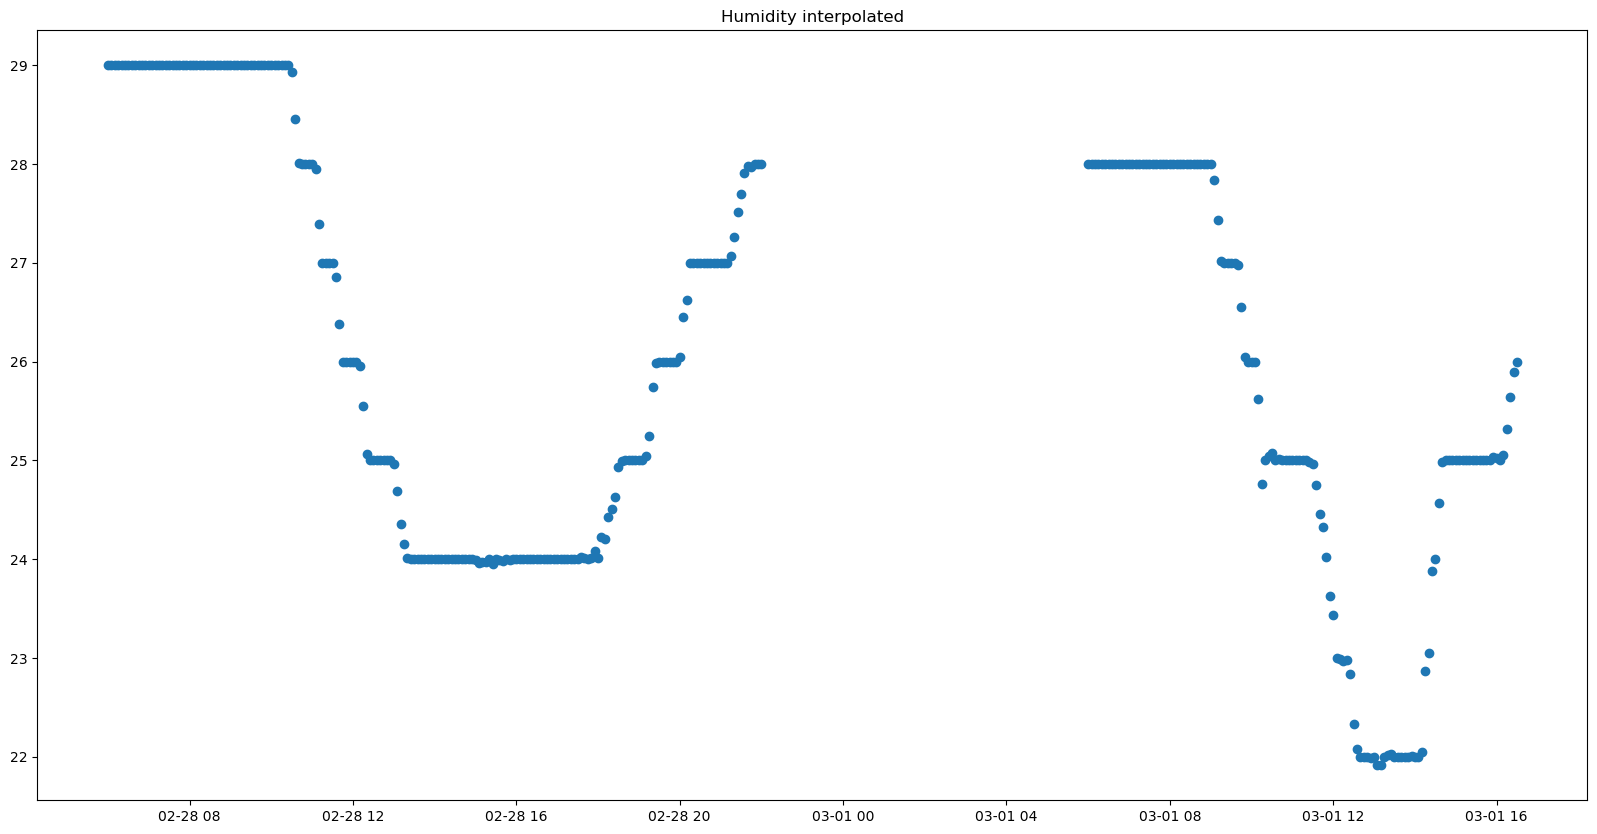

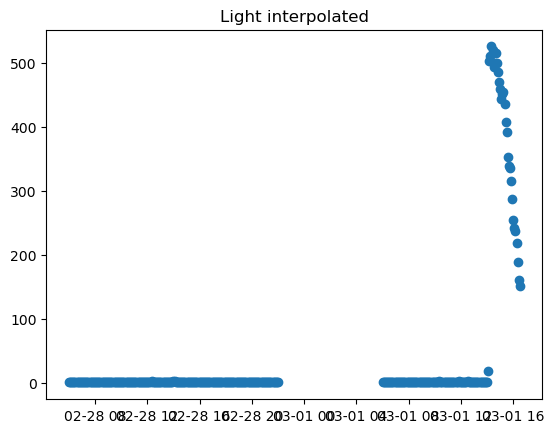

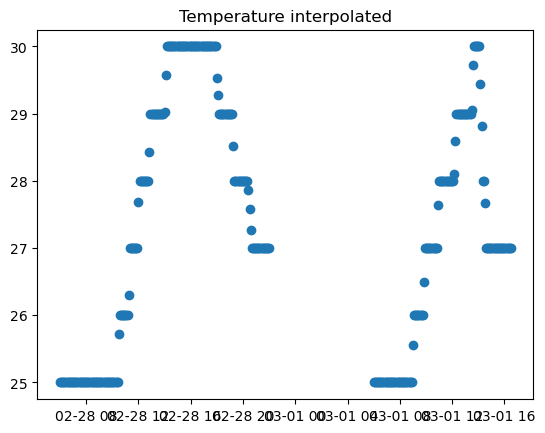

In [12]:
plt.figure(figsize=(20,10))
plt.plot(df_ip['Humidity'], marker='o', linestyle='', label='Humidity')
plt.title('Humidity interpolated')
plt.show()
plt.plot(df_ip['Light'], marker='o', linestyle='', label='Humidity')
plt.title('Light interpolated')
plt.show()
plt.plot(df_ip['Temperature'], marker='o', linestyle='', label='Temperature')
plt.title('Temperature interpolated')
plt.show()

The interpolated data looks much better. Still weird, that we have this gap in the data. But at least it's a consistent gap.

In [13]:
df_ip.describe()

,Humidity,Light,Temperature
count,320.000000,320.000000,320.000000
mean,25.986044,35.631456,27.315265
std,2.146955,116.130868,1.830944
min,21.913907,0.082268,25.000000
25%,24.000000,0.254867,25.000000
50%,25.688422,0.990193,27.000000
75%,28.000000,1.313316,29.000000
max,29.000000,526.298925,30.000000


Filling the gap: The gap looks like it is from 2022-02-28 00:00:00 to 2022-02-28 23:30:00. Before and after this gap the data is consistent and it's at night when the shopfloor might be closed. So we will interpolate them to create a smooth transition.

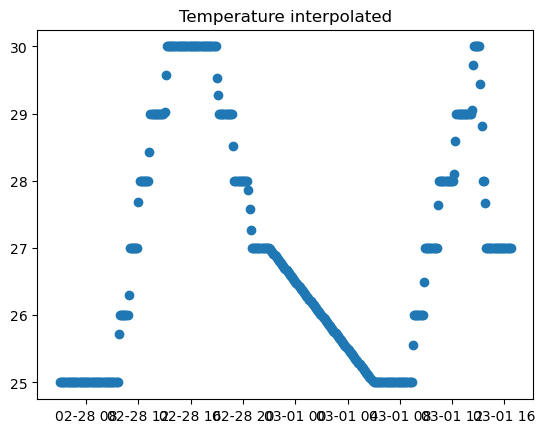

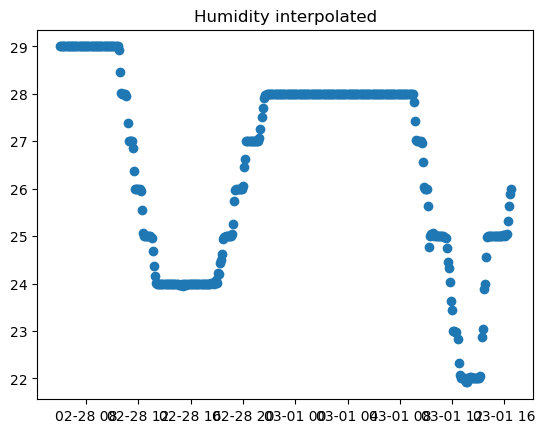

In [81]:
# using method 'linear' because the timestamps are evenly spaced
df_ip.interpolate(method='linear', inplace=True)
plt.plot(df_ip['Temperature'], marker='o', linestyle='', label='Temperature')
plt.title('Temperature interpolated')
plt.show()
plt.plot(df_ip['Humidity'], marker='o', linestyle='', label='Humidity')
plt.title('Humidity interpolated')
plt.show()

# Preparing the data for the model

Usualle for lagged features we would use a seasonal unit where the smallest is a day. Because we only have two days of data we then would not have enough data points for the model. So I decided that we use an hour as a unit.

In [82]:
# scale the data
from sklearn.preprocessing import MinMaxScaler
# get rid of the light data
df_ip.drop(columns='Light', inplace=True)
scaler = MinMaxScaler()
df_ip_scaled = pd.DataFrame(scaler.fit_transform(df_ip), columns=df_ip.columns, index=df_ip.index)
#df_ip_scaled = scaler.fit_transform(df_ip)
# data unscaled
print(df_ip.head)
# data scaled
print(df_ip_scaled.head)

<bound method NDFrame.head of                       Humidity  Temperature
Time                                       
2022-02-28 06:00:00  29.000000         25.0
2022-02-28 06:05:00  29.000000         25.0
2022-02-28 06:10:00  29.000000         25.0
2022-02-28 06:15:00  29.000000         25.0
2022-02-28 06:20:00  29.000000         25.0
...                        ...          ...
2022-03-01 16:10:00  25.055172         27.0
2022-03-01 16:15:00  25.319476         27.0
2022-03-01 16:20:00  25.637500         27.0
2022-03-01 16:25:00  25.892929         27.0
2022-03-01 16:30:00  26.000000         27.0

[415 rows x 2 columns]>
<bound method NDFrame.head of                      Humidity  Temperature
Time                                      
2022-02-28 06:00:00  1.000000          0.0
2022-02-28 06:05:00  1.000000          0.0
2022-02-28 06:10:00  1.000000          0.0
2022-02-28 06:15:00  1.000000          0.0
2022-02-28 06:20:00  1.000000          0.0
...                       ...          ...

In [83]:
import numpy as np

def create_sequences(data, n_timesteps):
    X = []
    y = []
    for i in range(len(data) - n_timesteps):
        # Input sequence (last n_timesteps of humidity, light, temperature)
        X.append(data[i:i + n_timesteps])
        # Target (humidity and temperature for the next timestep)
        y.append(data.iloc[i+n_timesteps][['Humidity', 'Temperature']])  # 0 for humidity, 2 for temperature
    return np.array(X), np.array(y)

n_timesteps = 12  # Use past 12 time steps (1 Hour) to predict the next step
X_scaled, y_scaled = create_sequences(df_ip_scaled, n_timesteps)

print(X_scaled.shape)
print(X_scaled[0])
print(y_scaled.shape)
print(y_scaled[0])

(403, 12, 2)
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]
(403, 2)
[1. 0.]


In [84]:
# create the test and train set
TEST_SPLIT = 0.1

#data = data.drop(columns = ['Wind', 'Solar'])
train_size = int(len(X_scaled) * (1-TEST_SPLIT))
test_size = len(X_scaled) - train_size

X_scaled_train = X_scaled[0:train_size]
X_scaled_test = X_scaled[train_size:len(y_scaled)]
y_scaled_train = y_scaled[0:train_size]
y_scaled_test = y_scaled[train_size:len(y_scaled)]


# Create the Model and train it

In [85]:
import tensorflow as tf
import keras as keras
from keras.models import Sequential
from keras.layers import *
from keras.callbacks import ModelCheckpoint
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.optimizers import Adam

model = Sequential()
model.add(InputLayer((n_timesteps, 2))) # 3 features
model.add(LSTM(64))
model.add(Dense(8, 'relu'))
model.add(Dense(2, 'linear'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 64)                17152     
                                                                 
 dense_4 (Dense)             (None, 8)                 520       
                                                                 
 dense_5 (Dense)             (None, 2)                 18        
                                                                 
Total params: 17,690
Trainable params: 17,690
Non-trainable params: 0
_________________________________________________________________


In [86]:
cp = ModelCheckpoint('models/model.h5', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

In [92]:
model.fit(X_scaled_train, y_scaled_train, epochs=50, batch_size=32, validation_split=0.1, callbacks=[cp])

Epoch 1/50
11/11 [==============================] - 2s 57ms/step - loss: 0.0057 - root_mean_squared_error: 0.0757 - val_loss: 0.0139 - val_root_mean_squared_error: 0.1181
Epoch 2/50
11/11 [==============================] - 0s 6ms/step - loss: 0.0041 - root_mean_squared_error: 0.0640 - val_loss: 0.0148 - val_root_mean_squared_error: 0.1215
Epoch 3/50
11/11 [==============================] - 0s 6ms/step - loss: 0.0036 - root_mean_squared_error: 0.0597 - val_loss: 0.0180 - val_root_mean_squared_error: 0.1343
Epoch 4/50
11/11 [==============================] - 0s 6ms/step - loss: 0.0034 - root_mean_squared_error: 0.0580 - val_loss: 0.0130 - val_root_mean_squared_error: 0.1141
Epoch 5/50
11/11 [==============================] - 0s 6ms/step - loss: 0.0034 - root_mean_squared_error: 0.0580 - val_loss: 0.0140 - val_root_mean_squared_error: 0.1183
Epoch 6/50
11/11 [==============================] - 0s 6ms/step - loss: 0.0032 - root_mean_squared_error: 0.0568 - val_loss: 0.0147 - val_root_mean_s

In [93]:
from keras.models import load_model
model = load_model('models/model.h5')

2/2 [==============================] - 0s 2ms/step
[[22.456846 29.030352]
 [22.464272 29.013668]
 [22.46501  28.988543]
 [22.455664 28.959927]
 [22.451332 28.93791 ]
 [22.444828 28.937197]
 [22.381166 29.031261]
 [22.306839 29.151304]
 [22.252054 29.25613 ]
 [22.21881  29.34557 ]
 [22.207535 29.4197  ]
 [22.214178 29.479263]
 [22.236305 29.527847]
 [22.324635 29.492443]
 [22.549747 29.360973]
 [22.852518 29.141167]
 [23.196575 28.9445  ]
 [23.528395 28.747215]
 [24.012043 28.293911]
 [24.463352 27.861368]
 [24.798178 27.537788]
 [25.012266 27.32005 ]
 [25.115852 27.197124]
 [25.127832 27.152319]
 [25.071533 27.165586]
 [25.00705  27.209114]
 [24.944654 27.253788]
 [24.91773  27.298035]
 [24.87017  27.331285]
 [24.841022 27.360004]
 [24.847294 27.369724]
 [24.847519 27.37008 ]
 [24.847519 27.37008 ]
 [24.847519 27.37008 ]
 [24.85224  27.367601]
 [24.855957 27.36614 ]
 [24.857002 27.36628 ]
 [24.863897 27.363281]
 [24.907515 27.341585]
 [24.99665  27.300041]
 [25.120403 27.247488]]
[[21.

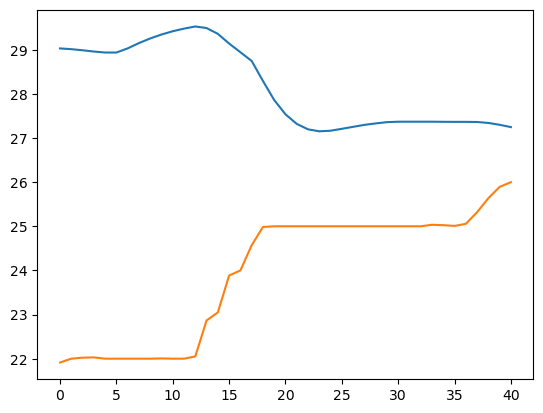

In [95]:
def inverse_scale(y_values_scaled):
    y_values_reshaped = scaler.inverse_transform(y_values_scaled)
    print(y_values_reshaped)
    return y_values_reshaped

def plot_predictions(model, X, y, start=0, end=100):
    y_predictions_scaled = model.predict(X)
    # rescale the data
    df_y_predictions = pd.DataFrame(inverse_scale(y_predictions_scaled))
    df_y_actuals = pd.DataFrame(inverse_scale(y))
    df = pd.DataFrame(data={'Predictions humidity':df_y_predictions[1], 'Actuals humdity':df_y_actuals[0], 'Predictions temperature':df_y_predictions[1], 'Actuals temperature': df_y_actuals[1] })
    plt.plot(df['Predictions humidity'][start:end])
    plt.plot(df['Actuals humdity'][start:end])
    return df#, MeanSquaredError(df_y_actuals, df_y_predictions)

df = plot_predictions(model, X_scaled_test, y_scaled_test)
#print(df)